<a href="https://colab.research.google.com/github/AkshayViru/CorrMCNN/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import math
import random
import warnings
import numpy as np
from sklearn import svm
import keras.backend as K
from keras.models import Model
from theano import tensor as T
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Add
from keras.engine.topology import Layer
from sklearn.metrics import accuracy_score
from keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from keras.layers.core import  Activation, Dense, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten

In [2]:
warnings.simplefilter("ignore")

HIDDEN_DIM_1 = 500
HIDDEN_DIM_2 = 300
HIDDEN_DIM_3 = 50      
EPOCHS = 100
BATCH_SIZE = 100
IMG_DIM = 392         
LAMBDA_1 = 0.02
LAMBDA_2 = 0.001
LAMBDA_3 = 0.05

In [3]:
class ZeroPadding(Layer):
    def __init__(self, **kwargs):
        super(ZeroPadding, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.zeros_like(x)

    def get_output_shape_for(self, input_shape):
        return input_shape

In [4]:
# Custom layer for finding MSE in L4 and L5 losses
class MSE_Loss_Calculator(Layer):
    def __init__(self, **kwargs):
        super(MSE_Loss_Calculator, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.mean(K.square(x[0] - x[1]), axis=-1)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0],input_shape[0][1])

In [5]:
# Custom layer for finding Correlation loss in L6 and L7 losses
class Correlation_Loss_Calculator(Layer):
    def __init__(self, LAMBDA, **kwargs):
        super(Correlation_Loss_Calculator, self).__init__(**kwargs)
        self.LAMBDA = LAMBDA

    def call(self, x, y, mask=None):
        x_center = x - K.mean(x, axis=0)
        y_center = y - K.mean(y, axis=0)
        corr_dr = K.sqrt(K.sum(x_center * x_center, axis=0) + 1e-8) * K.sqrt(K.sum(y_center * y_center, axis=0) + 1e-8)
        return K.sum((K.sum(x_center * y_center, axis=0)) / corr_dr) * self.LAMBDA

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0],input_shape[0][1])

In [6]:
# dummy loss functions -> actual loss is calculated using MSE_Loss_Calculator and Correlation_Loss_Calculator above

def mse_loss(y_true, y_pred):
    return y_pred

def corr_loss(y_true, y_pred):
    return y_pred

In [8]:
def get_model():
  
    inpx = Input(shape=(IMG_DIM,))
    inpy = Input(shape=(IMG_DIM,))

    # Encoding part
    # For first view
    hx = Reshape((28,14,1))(inpx)
    hx = Conv2D(128, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Conv2D(64, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Conv2D(49, (3, 3), activation='relu', padding='same')(hx)
    hx = MaxPooling2D((2, 2), padding='same')(hx)
    hx = Flatten()(hx)
    hidden_out_x1 = Dense(HIDDEN_DIM_1,activation='sigmoid')(hx)
    hidden_out_x2 = Dense(HIDDEN_DIM_2, activation='sigmoid',name='hid_l1')(hidden_out_x1)
    hidden_out_x3 = Dense(HIDDEN_DIM_3, activation='sigmoid',name='hid_l')(hidden_out_x2)

    # For second view
    hy = Reshape((28,14,1))(inpy)
    hy = Conv2D(128, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Conv2D(64, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Conv2D(49, (3, 3), activation='relu', padding='same')(hy)
    hy = MaxPooling2D((2, 2), padding='same')(hy)
    hy = Flatten()(hy)
    hidden_out_y1 = Dense(HIDDEN_DIM_1, activation='sigmoid')(hy)
    hidden_out_y2 = Dense(HIDDEN_DIM_2, activation='sigmoid',name='hid_r1')(hidden_out_y1)
    hidden_out_y3 = Dense(HIDDEN_DIM_3, activation='sigmoid',name='hid_r')(hidden_out_y2)

    # Joint common representation
    combined_out =  Add()([hidden_out_x3,hidden_out_y3]) 
    
    # Decoding
    # for first view

    # recxDec = Dense(HIDDEN_DIM_2,activation='sigmoid')(combined_out)
    # recxDec = Dense(HIDDEN_DIM_1, activation='sigmoid',name='hid_l1')(recxDec)
    # recxDec = Dense(IMG_DIM, activation='sigmoid',name='hid_l')(recxDec)

    # for second view

    recx = Dense(IMG_DIM)(combined_out)
    recy = Dense(IMG_DIM)(combined_out)
    
    intermediate_model = Model([inpx,inpy],[recx,recy,combined_out,hidden_out_x1,hidden_out_y1,hidden_out_x2,hidden_out_y2])

    [recx1,recy1,hX,hx_1a,hx_1b,hx_2a,hx_2b] = intermediate_model([inpx, ZeroPadding()(inpy)])
    [recx2,recy2,hY,hy_1a,hy_1b,hy_2a,hy_2b] = intermediate_model([ZeroPadding()(inpx), inpy ])
    [recx3,recy3,hZ,hz_1a,hz_1b,hz_2a,hz_2b] = intermediate_model([inpx, inpy])
    
    l6_loss = Correlation_Loss_Calculator(-LAMBDA_1)(hX,hY)
    l7_loss_1 = Correlation_Loss_Calculator(-LAMBDA_2)(hz_1a,hz_1b)
    l7_loss_2 = Correlation_Loss_Calculator(-LAMBDA_3)(hz_2a,hz_2b)

    # 1 = 1st hidden layer, 2 = 2nd hidden layer # a = first view, b = second view
    l4_loss_1a = MSE_Loss_Calculator()([hx_1a, hy_1a])
    l4_loss_1b = MSE_Loss_Calculator()([hx_1b, hy_1b])
    l4_loss_2a = MSE_Loss_Calculator()([hx_2a, hy_2a])
    l4_loss_2b = MSE_Loss_Calculator()([hx_2b, hy_2b])

    l5_loss_a = MSE_Loss_Calculator()([recx1, recx2])
    l5_loss_b = MSE_Loss_Calculator()([recy1, recy2])

    # recx3, recy3 -> take L1 loss of these
    # recx1, recy1 -> take L2 loss of these
    # recx2, recy2 -> take L3 loss of these

    model = Model([inpx,inpy],[recx3, recy3, recx1, recy1, recx2, recy2, l4_loss_1a, l4_loss_1b, l4_loss_2a, l4_loss_2b, l6_loss, l7_loss_1, l7_loss_2])
    model.compile(loss=["mse","mse","mse","mse","mse","mse",mse_loss,mse_loss,mse_loss,mse_loss,corr_loss,corr_loss,corr_loss], optimizer="adam")

    model.fit([train_left,train_right], [train_left, train_right, 
                                     train_left, train_right, 
                                     train_left, train_right,
                                     np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)),
              np.zeros((train_left.shape[0],HIDDEN_DIM_3)), 
              np.zeros((train_left.shape[0],HIDDEN_DIM_1)),np.zeros((train_left.shape[0],HIDDEN_DIM_2))],
              epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=1)
    
    return model, intermediate_model

In [9]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    X_train_l = x_train[:, :, :14]
    X_train_r = x_train[:, :, 14:]
    X_test_l = x_test[:, :, :14]
    X_test_r = x_test[:, :, 14:]
    
    return X_train_l, X_train_r, y_train, X_test_l, X_test_r, y_test

In [10]:
def visualize(left_view, right_view, y_train):

  for i in range(4):
    plt.subplot(1, 2, 1)
    left = left_view[i]
    pixels = np.array(left, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.subplot(1, 2, 2)
    right = right_view[i]
    pixels = np.array(right, dtype='uint8')
    pixels = pixels.reshape((28, 14))
    plt.title('Label is {label}'.format(label=y_train[i]))
    plt.imshow(pixels, cmap='gray')

    plt.show()

11493376/11490434 [==============================] - 0s 0us/step


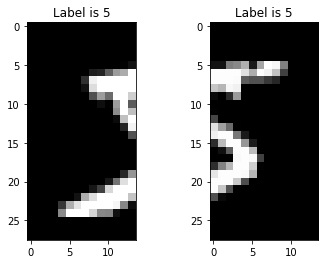

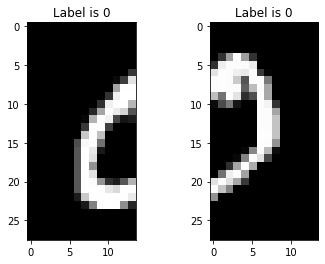

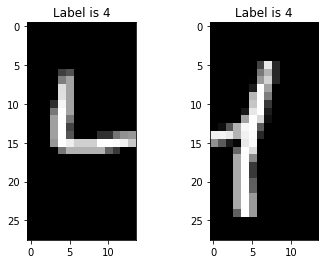

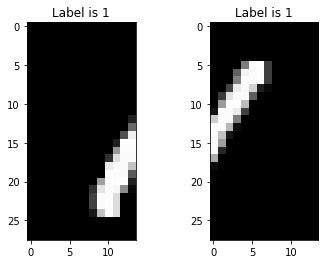

In [11]:
train_left, train_right, y_train, test_left, test_right, y_test = get_data()

visualize(train_left, train_right, y_train)

In [12]:
train_left = train_left.reshape(-1, IMG_DIM)
train_right = train_right.reshape(-1, IMG_DIM)

test_left = test_left.reshape(-1, IMG_DIM)
test_right = test_right.reshape(-1, IMG_DIM)

In [ ]:
model, intermediate_model = get_model()

model.fit([train_left,train_right], [train_left, train_right, 
                                     train_left, train_right, 
                                     train_left, train_right,
                                     np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_1)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)), np.zeros((train_left.shape[0],HIDDEN_DIM_2)),
              np.zeros((train_left.shape[0],HIDDEN_DIM_3)), 
              np.zeros((train_left.shape[0],HIDDEN_DIM_1)),np.zeros((train_left.shape[0],HIDDEN_DIM_2))],
              epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=1)

Epoch 1/100
 67/600 [==>...........................] - ETA: 43s - loss: 43402.4075 - model_loss: 6433.3483 - model_1_loss: 8036.6453 - model_2_loss: 6433.4640 - model_3_loss: 8036.7870 - model_4_loss: 6433.4588 - model_5_loss: 8036.8813 - mse__loss__calculator_loss: 0.2127 - mse__loss__calculator_1_loss: 0.2149 - mse__loss__calculator_2_loss: 0.0089 - mse__loss__calculator_3_loss: 0.0089 - correlation__loss__calculator_loss: -0.3171 - correlation__loss__calculator_1_loss: -0.0186 - correlation__loss__calculator_2_loss: -8.2825

In [ ]:
def test(direction, model, inp, idx):
    given = inp.reshape((28,14))
    f, axarr = plt.subplots(1,2,sharey=False)
    
    plt.title(y_test[idx])

    if(direction == 'left'):
      pred = model.predict([inp,np.zeros_like(inp)])
      axarr[0].imshow(given)
      axarr[1].imshow(pred[0].reshape((28,14)))

    else:
      pred = model.predict([np.zeros_like(inp),inp])
      axarr[1].imshow(given)
      axarr[0].imshow(pred[1].reshape((28,14)))

Left to Right testing


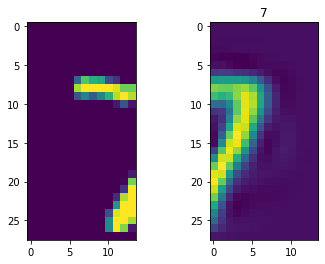

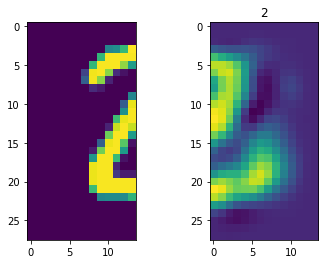

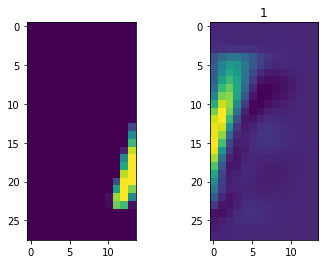

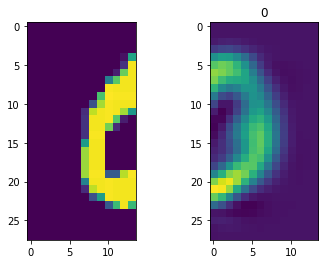

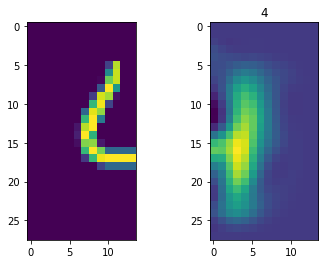

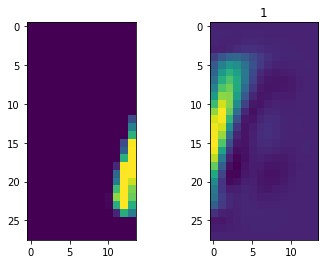

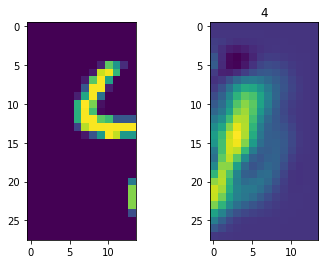

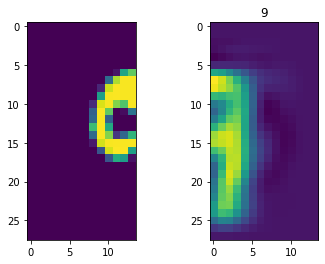

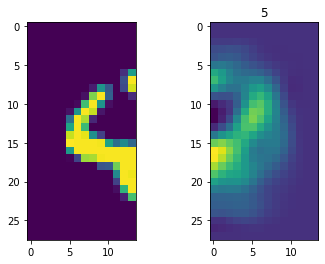

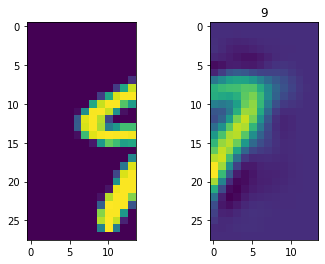

In [ ]:
print('Left to Right testing')
for i in range(10):
  test('left', model, test_left[i:i+1], i)

Right to Left testing


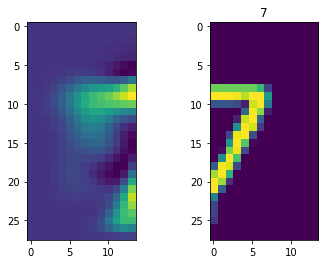

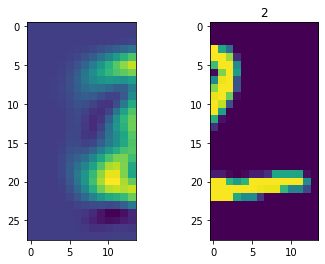

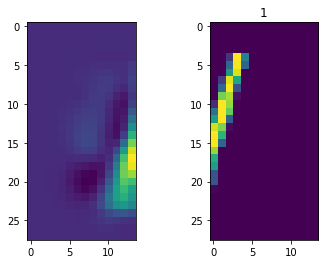

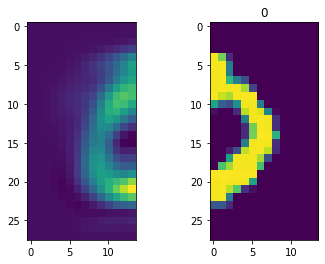

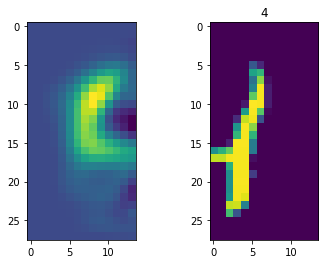

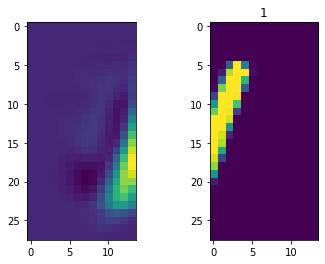

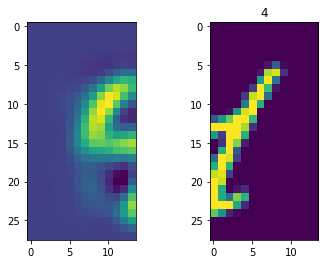

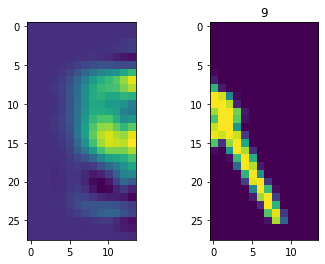

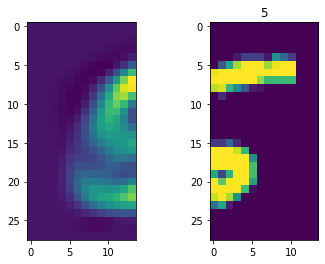

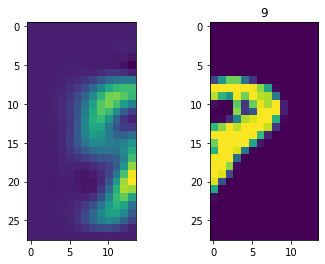

In [ ]:
print('Right to Left testing')
for i in range(10):
  test('right', model, test_right[i:i+1], i)